# Library

In [1]:
#Pytorch library
import torch
import torch.nn as nn
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Reproducible random
torch.manual_seed(12345)

# Data preprocessing

In [2]:
def normalize_dataset(x, y):
  x_mean = torch.mean(x)
  y_mean = torch.mean(y)
  x_std = torch.std(x)
  y_std = torch.std(y)
  x = (x-torch.mean(x))/torch.std(x)
  y = (y-torch.mean(y))/torch.std(y)
  return x, y, x_mean, y_mean, x_std, y_std

def normalize_input(x, x_mean, x_std):
  return (x-x_mean)/x_std

def denormalize_output(y, y_mean, y_std):
  return y*y_std+y_mean

def slice_dataset(x_dataset, y_dataset, n_train_percent):
  data_size = len(x_dataset)
  x_train = x_dataset[:int(data_size*n_train_percent)]
  x_test = x_dataset[int(data_size*n_train_percent):]
  y_train = y_dataset[:int(data_size*n_train_percent)]
  y_test = y_dataset[int(data_size*n_train_percent):]
  return x_train, y_train, x_test, y_test

# power flow dataset

In [3]:
df = pd.read_excel('dataset.xlsx')

In [4]:
dataset_length = len(df.index)

x_raw, y_raw = [], []
for i in range(dataset_length):
  x_raw.append(df.iloc[i, 1:-6])
  y_raw.append(df.iloc[i, -6:])

x_raw = torch.tensor(x_raw, dtype=torch.float)
y_raw = torch.tensor(y_raw, dtype=torch.float)

In [5]:
n_train_percent = 0.8
x_raw_train, y_raw_train, x_raw_test, y_raw_test = slice_dataset(x_raw, y_raw, n_train_percent)

x, y, x_mean, y_mean, x_std, y_std = normalize_dataset(x_raw, y_raw)
x_train, y_train, x_test, y_test = slice_dataset(x, y, n_train_percent)

# NN 1 hidden layer

In [6]:
class NeuralNetwork1(nn.Module):
  def __init__(self, **kwargs):
    super(NeuralNetwork1, self).__init__()
    self.input_size = kwargs.get('input_size', 12)  #number of input features
    self.hidden_size = kwargs.get('hidden_size', 32) #number of hidden layer nodes
    self.output_size = kwargs.get('output_size', 6) #number of output features

    #xavier initialization
    self.b1 = torch.randn(1)
    self.w1 = torch.randn(self.input_size, self.hidden_size)*torch.sqrt(torch.tensor(2)/(self.input_size+self.hidden_size))
    self.b2 = torch.randn(1)
    self.w2 = torch.randn(self.hidden_size, self.output_size)*torch.sqrt(torch.tensor(2)/(self.hidden_size+self.output_size))

    #learning rate
    self.lr = kwargs.get('lr', 0.001)
    #momentum
    self.beta1 = kwargs.get('betas', [0.9, 0.999])[0]
    self.Vdw1 = 0
    self.Vdw2 = 0
    #RMSprop
    self.beta2 = kwargs.get('betas', [0.9, 0.999])[1]
    self.Sdw1 = 0
    self.Sdw2 = 0
    self.epsilon = kwargs.get('eps', 1e-8)

  def forward(self, x):
    self.z1 = torch.matmul(x, self.w1) #unbiased
    self.a1 = self.sigmoid(self.z1)
    self.z2 = torch.matmul(self.a1, self.w2) #unbiased
    self.a2 = self.linear(self.z2)
    return self.a2

  def backward(self, x, y):
    #w2 backprop
    self.dL_da2 = y - self.a2 #from L2 loss function
    self.da2_dz2 = self.linear_prime(self.a2)
    self.dL_dz2 = self.dL_da2*self.da2_dz2
    self.dL_dw2 = torch.matmul(torch.t(self.a1), self.dL_dz2)
    self.dL_db2 = torch.sum(self.dL_dz2)

    #w1 backprop
    self.dz2_da1 = self.w2
    self.dL_da1 = torch.matmul(self.dL_dz2, torch.t(self.dz2_da1))
    self.da1_dz1 = self.sigmoid_prime(self.a1)
    self.dL_dz1 = self.dL_da1*self.da1_dz1
    self.dL_dw1 = torch.matmul(torch.t(x), self.dL_dz1)
    self.dL_db1 = torch.sum(self.dL_dz1)
    
    #gradient momentum
    self.Vdw1 = self.beta1*self.Vdw1 + self.dL_dw1*(1-self.beta1)
    self.Vdw2 = self.beta1*self.Vdw2 + self.dL_dw2*(1-self.beta1)

    #gradient RMSprop
    self.Sdw1 = self.beta2*self.Sdw1 + self.dL_dw1*self.dL_dw1*(1-self.beta2)
    self.Sdw2 = self.beta2*self.Sdw2 + self.dL_dw2*self.dL_dw2*(1-self.beta2)

    #adam optimizer parameter update
    self.b1 += self.dL_db1
    self.b2 += self.dL_db2

    self.w1 += lr*self.Vdw1/(torch.sqrt(self.Sdw1)+self.epsilon)
    self.w2 += lr*self.Vdw2/(torch.sqrt(self.Sdw2)+self.epsilon)
    
  def linear(self, x):
   return x

  def linear_prime(self, x):
   return torch.tensor(1)

  def relu(self, x):
   return torch.maximum(torch.tensor(0),x)

  def relu_prime(self, x):
    return (x > 0)*1

  def sigmoid(self, x):
    return 1/(1+torch.exp(-x))

  def sigmoid_prime(self, x):
    return x*(1-x)
  
  def tanh(self, x):
    return torch.tanh(x)

  def tanh_prime(self, x):
    return 1-(torch.tanh(x)**2)
  
  def save_weights(self, model):
    torch.save(model, "model")

In [7]:
input_size = 12
hidden_size = 16
output_size = 6
lr = 0.005
betas=[0.9, 0.999]

model = NeuralNetwork1(input_size=input_size, hidden_size=hidden_size, output_size=output_size, lr=lr, betas=betas)

train_loss_list, test_loss_list = [], []

for i in range(3001):
  y_train_prediction = model.forward(x_train)
  train_loss = torch.mean((y_train - y_train_prediction)**2).detach().item()
  model.backward(x_train, y_train)
  train_loss_list.append(train_loss)
    
  y_test_prediction = model(x_test)
  test_loss = torch.mean((y_test - y_test_prediction)**2).detach().item()
  test_loss_list.append(test_loss)
    
  if (i % 300) == 0:
    print("epoch #" + str(i) + " train loss: " + str(train_loss) + " test loss: " + str(test_loss))
  
model.save_weights(model)

epoch #0 train loss: 0.8494634032249451 test loss: 0.588303804397583
epoch #300 train loss: 0.0024580536410212517 test loss: 0.0018070799997076392
epoch #600 train loss: 0.0005168029456399381 test loss: 0.0005668202647939324
epoch #900 train loss: 0.00030307407723739743 test loss: 0.0003696093917824328
epoch #1200 train loss: 0.00022262657876126468 test loss: 0.00030041797435842454
epoch #1500 train loss: 0.00016103578673209995 test loss: 0.0002400452212896198
epoch #1800 train loss: 0.00011176605767104775 test loss: 0.0001830482651712373
epoch #2100 train loss: 7.374033884843811e-05 test loss: 0.00013061870413366705
epoch #2400 train loss: 4.597279621521011e-05 test loss: 8.550196071155369e-05
epoch #2700 train loss: 2.7037383915740065e-05 test loss: 5.03901501360815e-05
epoch #3000 train loss: 1.523577157058753e-05 test loss: 2.6478219297132455e-05


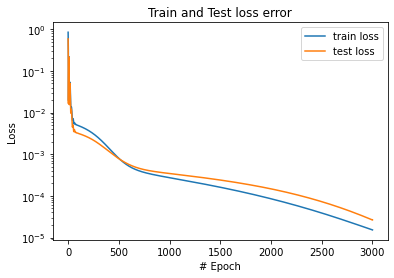

In [8]:
plt.title('Train and Test loss error')
plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.yscale('log')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [9]:
y_train_prediction = model.forward(x_train)
train_loss = torch.mean((y_train - y_train_prediction)**2).detach().item()

print("train output: \n" + str(denormalize_output(y_train, y_mean, y_std)[:3]))
print("train output prediction: \n" + str(denormalize_output(y_train_prediction, y_mean, y_std)[:3]))
print("train loss: " + str(train_loss))

print("----------------------------------------------------------------------")

y_test_prediction = model.forward(x_test)
test_loss = torch.mean((y_test - y_test_prediction)**2).detach().item()

print("test output: \n" + str(denormalize_output(y_test, y_mean, y_std)[-3:]))
print("test output prediction: \n" + str(denormalize_output(y_test_prediction, y_mean, y_std)[-3:]))
print("test loss: " + str(test_loss))

train output: 
tensor([[ 68.1540,  22.9530, 163.0000,   5.9100,  85.0000, -11.2270],
        [ 65.1980,  28.6150, 163.0000,   6.4940,  85.0000, -11.0550],
        [ 73.8900,  24.5100, 163.0000,   6.4930,  85.0000,  -9.9470]])
train output prediction: 
tensor([[ 68.2284,  23.2934, 162.9433,   5.9651,  84.9701, -11.3658],
        [ 65.4266,  28.6715, 163.0745,   6.4951,  85.0066, -11.0028],
        [ 73.9676,  24.5250, 162.8407,   6.4765,  85.0190, -10.1270]])
train loss: 1.5212584912660532e-05
----------------------------------------------------------------------
test output: 
tensor([[ 59.7800,  27.1710, 163.0000,   5.1010,  85.0000, -12.4110],
        [ 84.1720,  25.8880, 163.0000,   5.7580,  85.0000, -11.0430],
        [ 63.1330,  26.1500, 163.0000,   6.5280,  85.0000, -10.5690]])
test output prediction: 
tensor([[ 59.8714,  27.1467, 163.0831,   5.0483,  84.9659, -12.3631],
        [ 84.1759,  25.6720, 162.8800,   5.7310,  85.0256, -11.1402],
        [ 63.2826,  26.3590, 163.1924,   

# NN 2 hidden layer

In [12]:
class NeuralNetwork2(nn.Module):
  def __init__(self, **kwargs):
    super(NeuralNetwork2, self).__init__()
    self.input_size = kwargs.get('input_size', 12)  #number of input features
    self.hidden_size_1 = kwargs.get('hidden_size_1', 64) #number of hidden layer 1 nodes
    self.hidden_size_2 = kwargs.get('hidden_size_2', 32) #number of hidden layer 2 nodes
    self.output_size = kwargs.get('output_size', 6) #number of output features

    #xavier initialization
    self.b1 = torch.randn(1)
    self.w1 = torch.randn(self.input_size, self.hidden_size_1)*torch.sqrt(torch.tensor(2)/(self.input_size+self.hidden_size_1))
    self.b2 = torch.randn(1)
    self.w2 = torch.randn(self.hidden_size_1, self.hidden_size_2)*torch.sqrt(torch.tensor(2)/(self.hidden_size_1+self.hidden_size_2))
    self.b3 = torch.randn(1)
    self.w3 = torch.randn(self.hidden_size_2, self.output_size)*torch.sqrt(torch.tensor(2)/(self.hidden_size_2+self.output_size))

    self.lr = lr
    self.beta1 = 0.9
    self.Vdw1 = 0
    self.beta2 = 0.9
    self.Vdw2 = 0
    self.beta3 = 0.9
    self.Vdw3 = 0

    #learning rate
    self.lr = kwargs.get('lr', 0.001)
    #momentum
    self.beta1 = kwargs.get('betas', [0.9, 0.999])[0]
    self.Vdw1 = 0
    self.Vdw2 = 0
    self.Vdw3 = 0
    #RMSprop
    self.beta2 = kwargs.get('betas', [0.9, 0.999])[1]
    self.Sdw1 = 0
    self.Sdw2 = 0
    self.Sdw3 = 0
    self.epsilon = kwargs.get('eps', 1e-8)

  def forward(self, x):
    self.z1 = torch.matmul(x, self.w1)
    self.a1 = self.sigmoid(self.z1)
    self.z2 = torch.matmul(self.a1, self.w2)
    self.a2 = self.sigmoid(self.z2)
    self.z3 = torch.matmul(self.a2, self.w3)
    self.a3 = self.linear(self.z3)
    return self.a3
  
  def backward(self, x, y):
    #w3 backprop
    self.dL_da3 = y - self.a3 #from L2 loss function
    self.da3_dz3 = self.linear_prime(self.a3)
    self.dL_dz3 = self.dL_da3*self.da3_dz3
    self.dL_dw3 = torch.matmul(torch.t(self.a2), self.dL_dz3)
    self.dL_db3 = torch.sum(self.dL_dz3)

    #w2 backprop
    self.dz3_da2 = self.w3
    self.dL_da2 = torch.matmul(self.dL_dz3, torch.t(self.dz3_da2))
    self.da2_dz2 = self.sigmoid_prime(self.a2)
    self.dL_dz2 = self.dL_da2*self.da2_dz2
    self.dL_dw2 = torch.matmul(torch.t(self.a1), self.dL_dz2)
    self.dL_db2 = torch.sum(self.dL_dz2)

    #w1 backprop
    self.dz2_da1 = self.w2
    self.dL_da1 = torch.matmul(self.dL_dz2, torch.t(self.dz2_da1))
    self.da1_dz1 = self.sigmoid_prime(self.a1)
    self.dL_dz1 = self.dL_da1*self.da1_dz1
    self.dL_dw1 = torch.matmul(torch.t(x), self.dL_dz1)
    self.dL_db1 = torch.sum(self.dL_dz1)
    
    #gradient momentum
    self.Vdw1 = self.beta1*self.Vdw1 + self.dL_dw1*(1-self.beta1)
    self.Vdw2 = self.beta1*self.Vdw2 + self.dL_dw2*(1-self.beta1)
    self.Vdw3 = self.beta1*self.Vdw3 + self.dL_dw3*(1-self.beta1)

    #gradient RMSprop
    self.Sdw1 = self.beta2*self.Sdw1 + self.dL_dw1*self.dL_dw1*(1-self.beta2)
    self.Sdw2 = self.beta2*self.Sdw2 + self.dL_dw2*self.dL_dw2*(1-self.beta2)
    self.Sdw3 = self.beta2*self.Sdw3 + self.dL_dw3*self.dL_dw3*(1-self.beta2)

    #adam optimizer parameter update
    self.b1 += self.dL_db1
    self.b2 += self.dL_db2
    self.b3 += self.dL_db3
    self.w1 += lr*self.Vdw1/(torch.sqrt(self.Sdw1)+self.epsilon)
    self.w2 += lr*self.Vdw2/(torch.sqrt(self.Sdw2)+self.epsilon)
    self.w3 += lr*self.Vdw3/(torch.sqrt(self.Sdw3)+self.epsilon)
    
  def linear(self, x):
   return x

  def linear_prime(self, x):
   return torch.tensor(1)

  def relu(self, x):
   return torch.maximum(torch.tensor(0),x)

  def relu_prime(self, x):
    return (x > 0)*1

  def sigmoid(self, x):
    return 1/(1+torch.exp(-x))

  def sigmoid_prime(self, x):
    return x*(1-x)

  def tanh(self, x):
    return torch.tanh(x)

  def tanh_prime(self, x):
    return 1-(torch.tanh(x)**2)
  
  def save_weights(self, model):
    torch.save(model, "model")

In [13]:
input_size = 12
hidden_size_1 = 32
hidden_size_2 = 16
output_size = 6
lr = 0.005
betas=[0.9, 0.999]

model = NeuralNetwork2(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, 
                       output_size=output_size, lr=lr, betas=betas)

train_loss_list, test_loss_list = [], []

for i in range(1001):
  y_train_prediction = model.forward(x_train)
  train_loss = torch.mean((y_train - y_train_prediction)**2).detach().item()
  model.backward(x_train, y_train)
  train_loss_list.append(train_loss)
    
  y_test_prediction = model(x_test)
  test_loss = torch.mean((y_test - y_test_prediction)**2).detach().item()
  test_loss_list.append(test_loss)
    
  if (i % 100) == 0:
    print("epoch #" + str(i) + " train loss: " + str(train_loss) + " test loss: " + str(test_loss))
  
model.save_weights(model)

epoch #0 train loss: 1.1924597024917603 test loss: 0.8066102862358093
epoch #100 train loss: 0.006422047503292561 test loss: 0.004036979749798775
epoch #200 train loss: 0.00635143369436264 test loss: 0.003993262071162462
epoch #300 train loss: 0.006259326357394457 test loss: 0.003940497990697622
epoch #400 train loss: 0.006093445234000683 test loss: 0.003840153804048896
epoch #500 train loss: 0.005713101010769606 test loss: 0.003607475198805332
epoch #600 train loss: 0.004740087781101465 test loss: 0.003031163476407528
epoch #700 train loss: 0.0028130451682955027 test loss: 0.001967840129509568
epoch #800 train loss: 0.001247687148861587 test loss: 0.0010469859698787332
epoch #900 train loss: 0.000697065144777298 test loss: 0.0006369405891746283
epoch #1000 train loss: 0.0005288263200782239 test loss: 0.0005222075851634145


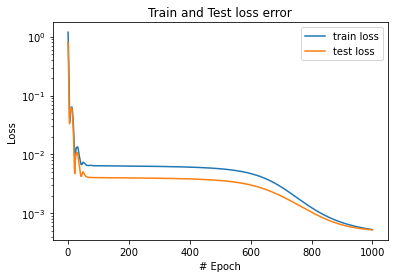

In [14]:
plt.title('Train and Test loss error')
plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.yscale('log')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [15]:
y_train_prediction = model.forward(x_train)
train_loss = torch.mean((y_train - y_train_prediction)**2).detach().item()

print("train output: \n" + str(denormalize_output(y_train, y_mean, y_std)[:3]))
print("train output prediction: \n" + str(denormalize_output(y_train_prediction, y_mean, y_std)[:3]))
print("train loss: " + str(train_loss))

print("----------------------------------------------------------------------")

y_test_prediction = model.forward(x_test)
test_loss = torch.mean((y_test - y_test_prediction)**2).detach().item()

print("test output: \n" + str(denormalize_output(y_test, y_mean, y_std)[-3:]))
print("test output prediction: \n" + str(denormalize_output(y_test_prediction, y_mean, y_std)[-3:]))
print("test loss: " + str(test_loss))

train output: 
tensor([[ 68.1540,  22.9530, 163.0000,   5.9100,  85.0000, -11.2270],
        [ 65.1980,  28.6150, 163.0000,   6.4940,  85.0000, -11.0550],
        [ 73.8900,  24.5100, 163.0000,   6.4930,  85.0000,  -9.9470]])
train output prediction: 
tensor([[ 68.3400,  27.2763, 162.7145,   6.3525,  84.9913, -10.7684],
        [ 64.5621,  27.4540, 162.4737,   6.2498,  84.9882, -10.5467],
        [ 74.1916,  26.9886, 163.1259,   6.5163,  85.0015, -11.1077]])
train loss: 0.0005278937751427293
----------------------------------------------------------------------
test output: 
tensor([[ 59.7800,  27.1710, 163.0000,   5.1010,  85.0000, -12.4110],
        [ 84.1720,  25.8880, 163.0000,   5.7580,  85.0000, -11.0430],
        [ 63.1330,  26.1500, 163.0000,   6.5280,  85.0000, -10.5690]])
test output prediction: 
tensor([[ 59.5241,  27.7029, 162.1145,   6.1081,  84.9793, -10.2555],
        [ 84.4801,  26.4853, 163.8348,   6.8034,  85.0192, -11.7064],
        [ 62.8716,  27.5352, 162.3645,   6